# 1D-CNN Model for ECG Classification
- The model used has 2 Conv. layers and 2 FC layers.
- This code repeat running the training process and produce all kinds of data which can be given, such as data needed for drawing loss and accuracy graph through epochs, and maximum test accuracy for each run.

## Get permission of Google Drive access

In [1]:
root_path = '.'

## File name settings

In [2]:
data_dir = 'mitdb'
train_name = 'train_ecg.hdf5'
test_name = 'test_ecg.hdf5'
all_name = 'all_ecg.hdf5'

model_dir = 'model'
model_name = 'conv2'
model_ext = '.pth'

csv_dir = 'csv'
csv_ext = '.csv'

csv_name = 'conv2'
csv_accs_name = 'accs_conv2'

## Import required packages

In [3]:
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffprivlib.mechanisms import Laplace

## GPU settings

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

GeForce 840M


## Define `ECG` `Dataset` class


In [5]:
class ECG(Dataset):
    def __init__(self, mode='train'):
        if mode == 'train':
            with h5py.File(os.path.join(root_path, data_dir, train_name), 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
        elif mode == 'test':
            with h5py.File(os.path.join(root_path, data_dir, test_name), 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
        elif mode == 'all':
            with h5py.File(os.path.join(root_path, data_dir, all_name), 'r') as hdf:
                self.x = hdf['x'][:]
                self.y = hdf['y'][:]
        else:
            raise ValueError('Argument of mode should be train, test, or all.')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

## Make Batch Generator

### Batch size
You can change it if you want.

In [6]:
batch_size = 32

### `DataLoader` for batch generating
`torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)`

In [7]:
train_dataset = ECG(mode='train')
test_dataset = ECG(mode='test')
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Size check for single batch

In [8]:
x_train, y_train = next(iter(train_loader))
print(x_train.size())
print(y_train.size())

torch.Size([32, 1, 128])
torch.Size([32])


### Number of total batches

In [9]:
total_batch = len(train_loader)
print(total_batch)

414


## Pytorch layer modules for **Conv1D** Network



### `Conv1d` layer
- `torch.nn.Conv1d(in_channels, out_channels, kernel_size)`

### `MaxPool1d` layer
- `torch.nn.MaxPool1d(kernel_size, stride=None)`
- Parameter `stride` follows `kernel_size`.

### `ReLU` layer
- `torch.nn.ReLU()`

### `Linear` layer
- `torch.nn.Linear(in_features, out_features, bias=True)`

### `Softmax` layer
- `torch.nn.Softmax(dim=None)`
- Parameter `dim` is usually set to `1`.

## Training process settings

In [10]:
run = 1
epoch = 400
lr = 0.001
epsilon = 7
min_diff = 1e-5

## Construct 1D CNN ECG classification model

In [11]:
class ECGConv1D(nn.Module):
    def __init__(self):
        super(ECGConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 32 x 16
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # differential privacy
        x_data = x.data.cpu().numpy()
        bound = np.dstack((np.max(x_data, axis=0), np.min(x_data, axis=0)))
        for i in range(bound.shape[0]):
            for j in range(bound.shape[1]):
                interval = bound[i][j]
                if interval[0] - interval[1] < min_diff:
                    interval[0] += min_diff * 0.5
                    interval[1] -= min_diff * 0.5
        for j in range(x_data.shape[1]):
            for k in range(x_data.shape[2]):
                dp = Laplace()
                dp = dp.set_epsilon(epsilon)
                dp = dp.set_sensitivity(bound[j][k][0] - bound[j][k][1])
                for i in range(x_data.shape[0]):
                    x_data[i][j][k] = dp.randomise(x_data[i][j][k])
        x.data = torch.tensor(x_data).requires_grad_(True).to(device)
        
        x = x.view(-1, 32 * 16)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.softmax4(x)
        return x        

## Traning function


In [12]:
def train(nrun, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = list()
    train_accs = list()

    test_losses = list()
    test_accs = list()

    best_test_acc = 0  # best test accuracy 

    for e in range(epoch):
        print("Epoch {} - ".format(e+1), end='')

        # train
        train_loss = 0.0
        correct, total = 0, 0
        for _, batch in enumerate(train_loader):
            x, label = batch  # get feature and label from a batch
            x, label = x.to(device), label.to(device)  # send to device
            optimizer.zero_grad()  # init all grads to zero
            output = model(x)  # forward propagation
            loss = criterion(output, label)  # calculate loss
            loss.backward()  # backward propagation
            optimizer.step()  # weight update

            train_loss += loss.item()
            correct += torch.sum(output.argmax(dim=1) == label).item()
            total += len(label)
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct / total)
        print("loss: {:.4f}, acc: {:.2f}%".format(train_losses[-1], train_accs[-1]*100), end=' / ')
        
        # test
        with torch.no_grad():
            test_loss = 0.0
            correct, total = 0, 0
            for _, batch in enumerate(test_loader):
                x, label = batch
                x, label = x.to(device), label.to(device)
                output = model(x)
                loss = criterion(output, label)
                
                test_loss += loss.item()
                correct += torch.sum(output.argmax(dim=1) == label).item()
                total += len(label)
            test_losses.append(test_loss / len(test_loader))
            test_accs.append(correct / total)
        print("test_loss: {:.4f}, test_acc: {:.2f}%".format(test_losses[-1], test_accs[-1]*100))

        # save model that has best validation accuracy
        if test_accs[-1] > best_test_acc:
            best_test_acc = test_accs[-1]
            torch.save(model.state_dict(), os.path.join(root_path, model_dir, '_'.join([model_name, str(nrun), 'best']) + model_ext))
    
        # save model for each 10 epochs
        if (e + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(root_path, model_dir, '_'.join([model_name, str(nrun), str(e+1)]) + model_ext))
    
    return train_losses, train_accs, test_losses, test_accs

## Training process

### Repeat for 10 times

In [13]:
best_test_accs = list()

for i in range(run):
    print('Run', i+1)
    
    seed = 0
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    ecgnet = ECGConv1D()  # init new model
    train_losses, train_accs, test_losses, test_accs = train(i, ecgnet.to(device))  # train

    best_test_accs.append(max(test_accs))  # get best test accuracy
    best_test_acc_epoch = np.array(test_accs).argmax() + 1
    print('Best test accuracy {:.2f}% in epoch {}.'.format(best_test_accs[-1]*100, best_test_acc_epoch))
    print('-' * 100)

    df = pd.DataFrame({  # save model training process into csv file
        'loss': train_losses,
        'test_loss': test_losses,
        'acc': train_accs,
        'test_acc': test_accs
    })
    df.to_csv(os.path.join(root_path, csv_dir, '_'.join([csv_name, str(i+1)]) + csv_ext))

df = pd.DataFrame({'best_test_acc': best_test_accs})  # save best test accuracy of each run
df.to_csv(os.path.join(root_path, csv_dir, csv_accs_name + csv_ext))

Run 1
Epoch 1 - loss: 1.3391, acc: 57.46% / test_loss: 1.1928, test_acc: 71.51%
Epoch 2 - loss: 1.1487, acc: 75.83% / test_loss: 1.1168, test_acc: 78.76%
Epoch 3 - loss: 1.1133, acc: 79.23% / test_loss: 1.0840, test_acc: 82.13%
Epoch 4 - loss: 1.0853, acc: 82.06% / test_loss: 1.0679, test_acc: 83.71%
Epoch 5 - loss: 1.0786, acc: 82.56% / test_loss: 1.0724, test_acc: 83.18%
Epoch 6 - loss: 1.0740, acc: 82.99% / test_loss: 1.0738, test_acc: 83.07%
Epoch 7 - loss: 1.0701, acc: 83.36% / test_loss: 1.0437, test_acc: 86.06%
Epoch 8 - loss: 1.0723, acc: 83.15% / test_loss: 1.0644, test_acc: 83.94%
Epoch 9 - loss: 1.0662, acc: 83.76% / test_loss: 1.0449, test_acc: 85.87%
Epoch 10 - loss: 1.0666, acc: 83.77% / test_loss: 1.0752, test_acc: 82.86%
Epoch 11 - loss: 1.0690, acc: 83.47% / test_loss: 1.0405, test_acc: 86.36%
Epoch 12 - loss: 1.0648, acc: 83.87% / test_loss: 1.0587, test_acc: 84.52%
Epoch 13 - loss: 1.0586, acc: 84.50% / test_loss: 1.0560, test_acc: 84.82%
Epoch 14 - loss: 1.0618, acc

Epoch 110 - loss: 1.0600, acc: 84.47% / test_loss: 1.0694, test_acc: 83.53%
Epoch 111 - loss: 1.0574, acc: 84.73% / test_loss: 1.0682, test_acc: 83.66%
Epoch 112 - loss: 1.0679, acc: 83.68% / test_loss: 1.0450, test_acc: 85.98%
Epoch 113 - loss: 1.0868, acc: 81.80% / test_loss: 1.0936, test_acc: 81.12%
Epoch 114 - loss: 1.0870, acc: 81.78% / test_loss: 1.0444, test_acc: 86.04%
Epoch 115 - loss: 1.0499, acc: 85.49% / test_loss: 1.0391, test_acc: 86.56%
Epoch 116 - loss: 1.0759, acc: 82.88% / test_loss: 1.0455, test_acc: 85.92%
Epoch 117 - loss: 1.0659, acc: 83.87% / test_loss: 1.0469, test_acc: 85.78%
Epoch 118 - loss: 1.1051, acc: 79.96% / test_loss: 1.0801, test_acc: 82.46%
Epoch 119 - loss: 1.0660, acc: 83.87% / test_loss: 1.0565, test_acc: 84.82%
Epoch 120 - loss: 1.0664, acc: 83.83% / test_loss: 1.0693, test_acc: 83.53%
Epoch 121 - loss: 1.0654, acc: 83.93% / test_loss: 1.0389, test_acc: 86.58%
Epoch 122 - loss: 1.1066, acc: 79.82% / test_loss: 1.0680, test_acc: 83.68%
Epoch 123 - 

Epoch 217 - loss: 1.0693, acc: 83.56% / test_loss: 1.0505, test_acc: 85.43%
Epoch 218 - loss: 1.0605, acc: 84.43% / test_loss: 1.1051, test_acc: 79.97%
Epoch 219 - loss: 1.0909, acc: 81.39% / test_loss: 1.0655, test_acc: 83.93%
Epoch 220 - loss: 1.0622, acc: 84.25% / test_loss: 1.0508, test_acc: 85.41%
Epoch 221 - loss: 1.0736, acc: 83.13% / test_loss: 1.0727, test_acc: 83.21%
Epoch 222 - loss: 1.1370, acc: 76.79% / test_loss: 1.1289, test_acc: 77.59%
Epoch 223 - loss: 1.0735, acc: 83.13% / test_loss: 1.0445, test_acc: 86.02%
Epoch 224 - loss: 1.0615, acc: 84.33% / test_loss: 1.0473, test_acc: 85.75%
Epoch 225 - loss: 1.0726, acc: 83.21% / test_loss: 1.0463, test_acc: 85.85%
Epoch 226 - loss: 1.0649, acc: 83.99% / test_loss: 1.0423, test_acc: 86.24%
Epoch 227 - loss: 1.0636, acc: 84.11% / test_loss: 1.0528, test_acc: 85.20%
Epoch 228 - loss: 1.0612, acc: 84.36% / test_loss: 1.0457, test_acc: 85.92%
Epoch 229 - loss: 1.0670, acc: 83.78% / test_loss: 1.0684, test_acc: 83.64%
Epoch 230 - 

Epoch 324 - loss: 1.0564, acc: 84.85% / test_loss: 1.0463, test_acc: 85.85%
Epoch 325 - loss: 1.0565, acc: 84.83% / test_loss: 1.0439, test_acc: 86.10%
Epoch 326 - loss: 1.0652, acc: 83.96% / test_loss: 1.0651, test_acc: 83.97%
Epoch 327 - loss: 1.0597, acc: 84.51% / test_loss: 1.0466, test_acc: 85.82%
Epoch 328 - loss: 1.0504, acc: 85.44% / test_loss: 1.0380, test_acc: 86.67%
Epoch 329 - loss: 1.0517, acc: 85.30% / test_loss: 1.0367, test_acc: 86.80%
Epoch 330 - loss: 1.0488, acc: 85.60% / test_loss: 1.0361, test_acc: 86.88%
Epoch 331 - loss: 1.0553, acc: 84.95% / test_loss: 1.0516, test_acc: 85.32%
Epoch 332 - loss: 1.0543, acc: 85.05% / test_loss: 1.0490, test_acc: 85.58%
Epoch 333 - loss: 1.0654, acc: 83.93% / test_loss: 1.0681, test_acc: 83.67%
Epoch 334 - loss: 1.0683, acc: 83.64% / test_loss: 1.0579, test_acc: 84.70%
Epoch 335 - loss: 1.0675, acc: 83.73% / test_loss: 1.0518, test_acc: 85.29%
Epoch 336 - loss: 1.0706, acc: 83.43% / test_loss: 1.0451, test_acc: 85.98%
Epoch 337 - 

## Print the best test accuracy of each run

In [14]:
for i, a in enumerate(best_test_accs):
    print('Run {}: {:.2f}%'.format(i+1, a*100))

Run 1: 87.34%


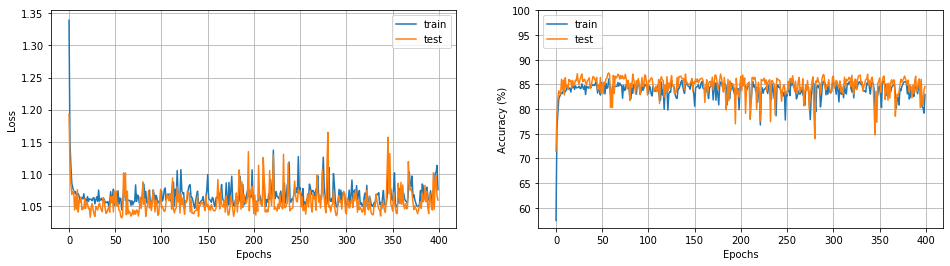

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[0].set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid()
ax[0].legend(['train', 'test'], loc='upper right')

ax[1].plot(np.asarray(train_accs) * 100)
ax[1].plot(np.asarray(test_accs) * 100)
ax[1].set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim(top=100)
ax[1].grid()
ax[1].legend(['train', 'test'], loc='upper left')

fig.savefig('conv2_split.pdf', bbox_inches='tight')